# **Single-Agent & Multi-Agent Stateful Chatbot using LangGraph and ChatGroq**

-->In this project, I built a stateful chatbot workflow using LangGraph and ChatGroq (Gemma2-9b-It). The workflow is designed to handle messages sequentially through multiple processing nodes, maintaining a structured state throughout the conversation.

**Key Components:**

**1. State Definition**

A State object is defined using TypedDict, containing:
* messages: a list of messages exchanged in the conversation, annotated with add_messages to track incoming messages.
* sentiment: a string to store the sentiment of the latest message.

**2. Workflow Nodes**

The workflow consists of four nodes, each performing a specific task:
* Preprocessing Node (preprocess): Cleans and trims the latest user message to remove extra whitespace.
* Sentiment Analysis Node (analyze_sentiment): Determines whether the user’s message is “positive” or “neutral” based on simple keyword detection.
* Chatbot Node (chatbot): Uses the LLM (ChatGroq) to generate responses based on the conversation history.
* Logging Node (logger): Logs the message content and detected sentiment for debugging and monitoring purposes.

**3. StateGraph Construction**

* Nodes are added to a StateGraph object in a defined sequence.
* Edges are created to define the workflow:
* START → preprocess → analyze_sentiment → chatbot → logger → END.
* The graph is then compiled into a runnable object, allowing messages to flow through the nodes automatically.

**4. Visualization**

* We attempted to visualize the workflow using draw_mermaid_png() to generate a Mermaid-based PNG graph.
* Visualization may fail in Jupyter due to environment constraints (e.g., pyppeteer/Chromium issues), but the workflow itself remains functional.

**5. Message Processing**

* Messages are sent to the compiled graph using invoke().
* The graph processes each message sequentially through the nodes.
* The final state captures:
* The LLM’s response (messages[-1].content).
* Detected sentiment (sentiment).

**Results**

* Example runs demonstrate how different input messages are processed, producing both chatbot responses and sentiment analysis results.
* Multiple messages can be handled iteratively while maintaining state, enabling a stateful conversational experience.

**Key Advantages:**

* Modular design allows adding more nodes (e.g., topic detection, translation) easily.
* Maintains conversation context, unlike stateless models.
* Supports multi-agent workflows in future expansions.

**Technologies Used:**

* LangGraph: For building and managing stateful node-based workflows.
* LangChain & ChatGroq: For LLM-based chatbot responses.
* Python (TypedDict & Annotated types): For clear state typing and structure.

In [ ]:
# pip install langgraph langsmith
# pip install langchain langchain_groq langchain_community

# Import libraries

In [ ]:
from langchain_groq import ChatGroq
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

**Initialize the Groq LLM client**

**`groq_api_key` is our API key for authentication with Groq services**

**`llm` is an instance of ChatGroq using the model "Gemma2-9b-It"**

**`langsmith` seems to be your LangSmith API key for logging, tracking, or evaluation purposes**

In [ ]:
groq_api_key='gsk.......PTO'
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
langsmith='lsv2..........26d'

**This `llm` object allows you to send messages to the "Gemma2-9b-It" model and receive responses from it.**

In [3]:
llm= ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000011730C5FA10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000011730E44680>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

**Define the structure of the state used in the graph**

**`State` is a TypedDict with a single key 'messages'**

- 'messages' is a list that will store chat messages
- `add_messages` is a helper that manages appending new messages

**Create a StateGraph instance using this State**
**`graph_builder` will be used to add nodes and edges for the workflow**


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder= StateGraph(State)
graph_builder

* Define the chatbot node for the StateGraph
* This function takes the current `state` as input
* It calls the LLM (`llm`) with the state's messages
* Returns a new state dictionary containing only the updated 'messages'

In [5]:
def chatbot(state: State):
    return {"messages": llm.invoke(state["messages"])}

In [ ]:
graph_builder.add_node("chatbot", chatbot)  # This node will execute the `chatbot` function whenever the graph reaches it

* Define the flow of the graph by connecting nodes with edges
* Connect the START node to the "chatbot" node
* This means the graph execution will begin at the chatbot node
* Connect the "chatbot" node to the END node
* This marks the chatbot as the final step before the graph finishes

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [ ]:
# Compile the StateGraph into an executable graph object
graph=graph_builder.compile()  # `graph` now contains the full workflow and can be invoked with input states

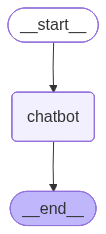

In [ ]:
# generates a visual representation of the workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# Start an interactive loop with the user
while True:
    # Take input from the user
    user_input = input("User: ")

    # Exit the loop if user types 'quit' or 'q'
    if user_input.lower() in ["quit", "q"]:
        print("Good Bye")
        break

    # Stream events from the graph by sending the user's message as state
    for event in graph.stream({'messages': ("user", user_input)}):
        # Print all key-value pairs in the event for debugging
        print(event.values())
        
        # Iterate over event values to access the state
        for value in event.values():
            # Print the full message history
            print(value['messages'])
            
            # Print the latest assistant response
            print("Assistant:", value["messages"].content)

dict_values([{'messages': AIMessage(content="## Data Scientist Scope in 2025: Expanding Horizons\n\nThe data science landscape is constantly evolving, and by 2025, data scientists will be in even higher demand than today. \n\nHere's a glimpse into the potential scope of data science in 2025:\n\n**1. Growing Demand & Specialization:**\n\n* **Increased demand:** The volume of data generated will continue to explode, driving a surge in demand for skilled data scientists across industries. \n* **Niche specialization:** We'll see more data scientists specializing in specific domains like healthcare, finance, cybersecurity, or AI ethics. \n* **Focus on practical skills:**  Emphasis will shift towards applying data science to real-world problems, requiring data scientists to be both technically proficient and business-savvy.\n\n**2.  Emerging Technologies & Trends:**\n\n* **AI & Machine Learning:**  Data scientists will play a crucial role in developing and deploying advanced AI models across

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    sentiment: str

# Define the structure of the state for the multi-node workflow
# `State` includes:
#   - messages: a list of chat messages, managed with add_messages
#   - sentiment: a string representing the detected sentiment

# 1. Preprocessing Node
# Cleans the last message in the state by stripping whitespace
# Updates the state's messages list
def preprocess(state: State) -> State:
    cleaned = state["messages"][-1].content.strip()
    state["messages"][-1].content = cleaned
    return state

# 2. Sentiment Analysis Node
# Analyzes the last message's content
# Sets 'sentiment' to "positive" if the message contains "good", otherwise "neutral"
def analyze_sentiment(state: State) -> State:
    msg = state["messages"][-1].content
    state["sentiment"] = "positive" if "good" in msg else "neutral"
    return state

# 3. Chatbot Node
# Sends the current messages to the LLM and returns a new state with updated messages
# Note: This currently overwrites other state keys like 'sentiment'
def chatbot(state: State) -> State:
    return {"messages": llm.invoke(state['messages'])}

# 4. Logging Node
# Prints the latest message and its sentiment for debugging/logging purposes
# Returns the state unchanged
def logger(state: State) -> State:
    print(f"LOG: {state['messages'][-1].content}, Sentiment: {state.get('sentiment')}")
    return state


**Build the multi-node StateGraph workflow**

In [ ]:
builder = StateGraph(State)
builder.add_node("preprocess", preprocess)                # "preprocess": cleans incoming messages
builder.add_node("analyze_sentiment", analyze_sentiment)  # "analyze_sentiment": analyzes message sentiment
builder.add_node("chatbot", chatbot)                      # "chatbot": generates a response using the LLM
builder.add_node("logger", logger)                        # "logger": prints messages and sentiment for debugging

**Define the flow of the StateGraph**

**Connect nodes using edges to determine the order of execution:**

In [ ]:
builder.add_edge(START, "preprocess")                # START → preprocess: workflow starts with preprocessing
builder.add_edge("preprocess", "analyze_sentiment")  # preprocess → analyze_sentiment: after preprocessing, analyze sentiment
builder.add_edge("analyze_sentiment", "chatbot")     # analyze_sentiment → chatbot: send the analyzed message to the chatbot
builder.add_edge("chatbot", "logger")                # chatbot → logger: log the chatbot response and sentiment
builder.add_edge("logger", END)                      # logger → END: workflow ends after logging

In [ ]:
# Compile the StateGraph
graph1 = builder.compile()

In [ ]:
# Draw the graph
try:
    display(Image(graph1.get_graph().draw_mermaid_png()))
except Exception :
    pass

**Invoke the compiled StateGraph with user messages**

* Send a message to the graph using `invoke()`, which runs the workflow from START to END
* The graph processes the message through all nodes: preprocess → analyze_sentiment → chatbot → logger
* Capture the final state returned by the graph

In [18]:
# Invoke the graph
input_message = "hi i am Abhinay."
final_state = graph1.invoke({"messages": ("user", input_message)})

# Print the final state
print("Final State:", final_state)
print("Chatbot's response:", final_state['messages'][-1].content)
print("Detected Sentiment:", final_state['sentiment'])

input_message_2 = "This is a neutral message."
final_state_2 = graph1.invoke({"messages": ("user", input_message_2)})
print("Final State 2:", final_state_2)
print("Chatbot's response 2:", final_state_2['messages'][-1].content)
print("Detected Sentiment 2:", final_state_2['sentiment'])

LOG: Hello Abhinay,

It's nice to meet you! What can I do for you today? 😊
, Sentiment: neutral
Final State: {'messages': [HumanMessage(content='hi i am Abhinay.', additional_kwargs={}, response_metadata={}, id='e36cd52e-dd8c-49ec-823d-cfaddf8d0ab4'), AIMessage(content="Hello Abhinay,\n\nIt's nice to meet you! What can I do for you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 16, 'total_tokens': 42, 'completion_time': 0.047272727, 'prompt_time': 0.001266269, 'queue_time': 0.2536697, 'total_time': 0.048538996}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--3f355d91-be8c-418c-80ec-3c30bdcd1074-0', usage_metadata={'input_tokens': 16, 'output_tokens': 26, 'total_tokens': 42})], 'sentiment': 'neutral'}
Chatbot's response: Hello Abhinay,

It's nice to meet you! What can I do for you today? 😊

Detected Sentiment: neutral
LOG: I understand. Please let m